In [1]:
import datetime as dt

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from jax import random
from numpyro.infer import MCMC, NUTS
from scipy.special import expit
from sklearn.preprocessing import LabelEncoder

assert numpyro.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [2]:
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

In [5]:
import geopandas as gpd
plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
bland = plz.set_index("plz")['bundesland']

In [6]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [7]:
df = df[df.date >= '2021-11-01']
df = df[df.reason.isin(['N'])]
df['omi'] = df.lineage.apply(lambda x: int((x in ['B.1.1.529','BA.1','BA.2', 'BA.3']))) 
all = df.groupby(['sending_pc','date'])['omi'].count()#
omi = df.groupby(['sending_pc','date'])['omi'].apply(lambda x: (x == 1).sum()).fillna(0).astype(int)
df_reshaped = pd.concat({'all': all, 'omi': omi}, axis=1).reset_index()
today = pd.Timestamp(str(dt.date.today()))
df_reshaped['days'] = (df_reshaped.date-today).dt.days
df_reshaped['sending_area'] = df_reshaped.sending_pc.apply(lambda x: int(x[0]))
lab_counts = df_reshaped[df_reshaped.date > '2021-12-01'].groupby('sending_pc')['all'].sum()
# df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['']))].copy()
df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['22767','70193','24106']))].copy().dropna()
le = LabelEncoder()
df_filtered['sending_pc_ID'] = le.fit_transform(df_filtered['sending_pc'].values)

df_filtered = df_filtered.merge(bland, left_on='sending_pc', right_index=True)#.dropna()
df_filtered['bundesland'] = pd.Categorical(df_filtered['bundesland'].values)

omi_counts = df_filtered["omi"].values
total_counts = df_filtered["all"].values
sample_day = df_filtered["days"].values
sending_pc_ID = df_filtered['sending_pc_ID'].values
sending_area = df_filtered['bundesland'].values.codes

In [8]:
df_filtered

sending_pc       date  all  omi  days  sending_area  sending_pc_ID  \
0          01067 2021-11-01    0    0   -74             0              0   
1          01067 2021-11-02    8    0   -73             0              0   
2          01067 2021-11-03    0    0   -72             0              0   
3          01067 2021-11-04   69    0   -71             0              0   
4          01067 2021-11-05    0    0   -70             0              0   
...          ...        ...  ...  ...   ...           ...            ...   
18242      90530 2022-01-06    0    0    -8             9             94   
18243      90530 2022-01-07    0    0    -7             9             94   
18244      90530 2022-01-08    0    0    -6             9             94   
18245      90530 2022-01-09    0    0    -5             9             94   
18246      90530 2022-01-10    0    0    -4             9             94   

      bundesland  
0        Sachsen  
1        Sachsen  
2        Sachsen  
3        Sachsen  
4        Sachsen  
...          ...  
18242     Bayern  
18243     Bayern  
18244     Bayern  
18245     Bayern  
18246     Bayern  

[7881 rows x 8 columns]

Text(0, 0.5, 'Proportion')

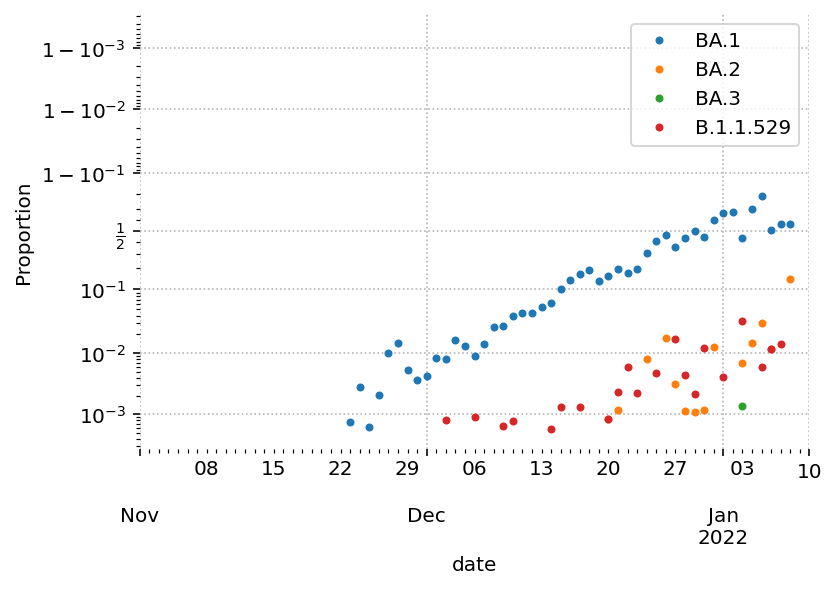

In [9]:
foo = pd.crosstab(df.date, df.lineage.cat.remove_unused_categories())
for i in ['BA.1','BA.2','BA.3','B.1.1.529']:
    (foo[i]/foo.sum(1)).plot(ls="",marker='.', label=i)
plt.yscale('logit')
plt.legend()
plt.ylabel('Proportion')

In [10]:
print(foo.loc["2021-12-01":,:].sum(0).sort_values().to_string())

lineage
B                0
AY.37            0
AY.46.4          0
AY.52            0
AY.55            0
AY.66            0
AY.107           0
AY.67            0
AY.89            0
AY.91.1          0
AY.23.2          0
AY.5.2           0
AY.16            0
B.1.639          0
AY.43.3          0
AY.46.3          0
B.1.1.7          0
AU.2             0
AY.3.1           0
AY.27            0
AY.43.2          0
B.1.351          0
AY.11            1
B.1.1.263        1
AY.50            1
AY.53            1
AY.54            1
AY.58            1
AY.60            1
AY.39.1.1        1
AY.82            1
AY.95            1
AY.99.2          1
AY.19            1
AY.119.1         1
AY.23.1          1
AY.46.5          1
AY.77            1
AY.104           1
BA.3             1
AY.105           1
AY.62            1
AY.13            1
B.1.1            1
AY.101           1
AY.93            1
B.1.110          1
AY.68            2
AY.43.5          2
AY.56            2
AY.20.1          2
AY.70            2
AY.8

(18951.0, 19006.0)

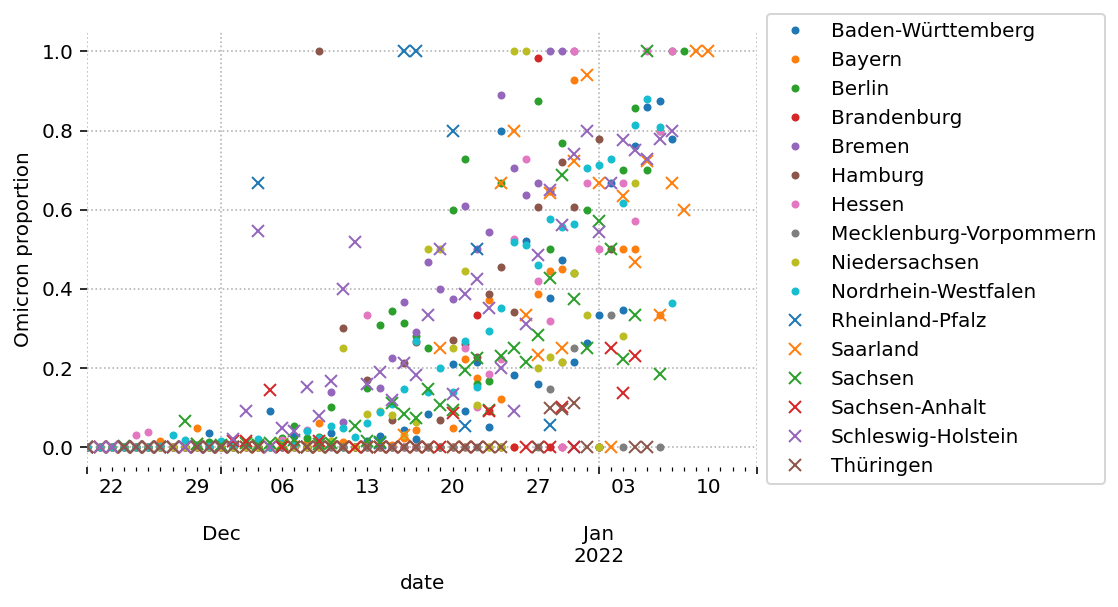

In [11]:
omi_bl = df_filtered.set_index(['bundesland','sending_pc','date']).sort_index()
omi_bl = omi_bl.sum(level=[0,2]).loc[:,"2021-11-20":,:]
omi_bl['prop'] = omi_bl.omi / omi_bl['all']
for i,r in enumerate(omi_bl.index.levels[0]):
    omi_bl.loc[r]['prop'].plot(ls="", marker="." if i < 10 else "x", label=r)
#omi_bl.mean(level=1)['prop'].plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
#plt.yscale('logit')
plt.ylabel("Omicron proportion")
plt.xlim((None, np.datetime64("today")))

In [125]:
from numpyro.infer.reparam import LocScaleReparam
import jax.numpy as jnp
#reparam_config = {k: LocScaleReparam(0) for k in ["a_area", "a_lab", "b"]}

#@numpyro.handlers.reparam(config=reparam_config)
def model3(sending_pc, sending_area, sending_pc_to_area, sample_day, total_counts,omi_counts=None):
    mu_a = numpyro.sample("mu_a", dist.Normal(0, 5.0))
    sigma_a_area = numpyro.sample("sigma_a_area", dist.HalfNormal(5.0))
    #sigma_a_lab = numpyro.sample("sigma_a_lab", dist.HalfNormal(2.))
    mu_b = numpyro.sample("mu_b", dist.Normal(0.2, 0.2))
    sigma_b_area = numpyro.sample("sigma_b_area", dist.HalfNormal(.1))
    #sigma_b_lab = numpyro.sample("sigma_b_lab", dist.HalfNormal(.01))


    n_labs = len(np.unique(sending_pc))
    n_areas = len(np.unique(sending_pc_to_area))

    with numpyro.plate("plate_i", n_areas):
        a_area = numpyro.sample("a_area", dist.Normal(mu_a, sigma_a_area))
        b = numpyro.sample("b", dist.Normal(mu_b, sigma_b_area))

    #with numpyro.plate("plate_j", n_labs):
    #    a_lab = numpyro.sample("a_lab", dist.Normal(0, sigma_a_lab))
        #b_lab = numpyro.sample("b_lab", dist.Normal(0, 0.01))


    logit_est =  a_area[sending_area] + b[sending_area] * sample_day #a_lab[sending_pc] +
        
    rho = 20.
    alpha = rho * jnp.clip(jnp.exp(logit_est), 1e-9, 1e9)

    with numpyro.plate("data", len(sending_pc)):
        #numpyro.sample("obs", dist.BinomialLogits(logits=logit_est, total_count=total_counts), obs=omi_counts)
        numpyro.sample("obs", dist.BetaBinomial(concentration1 = alpha, concentration0 = rho, total_count=total_counts), obs=omi_counts)



In [126]:
sending_pc_to_area = pd.DataFrame({"sending_pc": sending_pc_ID, "sending_area": sending_area}).groupby(['sending_pc']).sending_area.first().values

In [127]:
nuts_kernel = NUTS(model3, init_strategy=numpyro.infer.init_to_median)#, dense_mass=[("mu_a","mu_b","sigma_a_area","sigma_a_lab","sigma_b_area")])

mcmc = MCMC(nuts_kernel, num_samples=500, num_warmup=500)
rng_key = random.PRNGKey(42)
mcmc.run(rng_key, sending_pc_ID, sending_area, sending_pc_to_area, sample_day, total_counts, omi_counts=omi_counts)

sample: 100%|██████████| 1000/1000 [02:32<00:00,  6.55it/s, 31 steps of size 1.62e-01. acc. prob=0.89] 


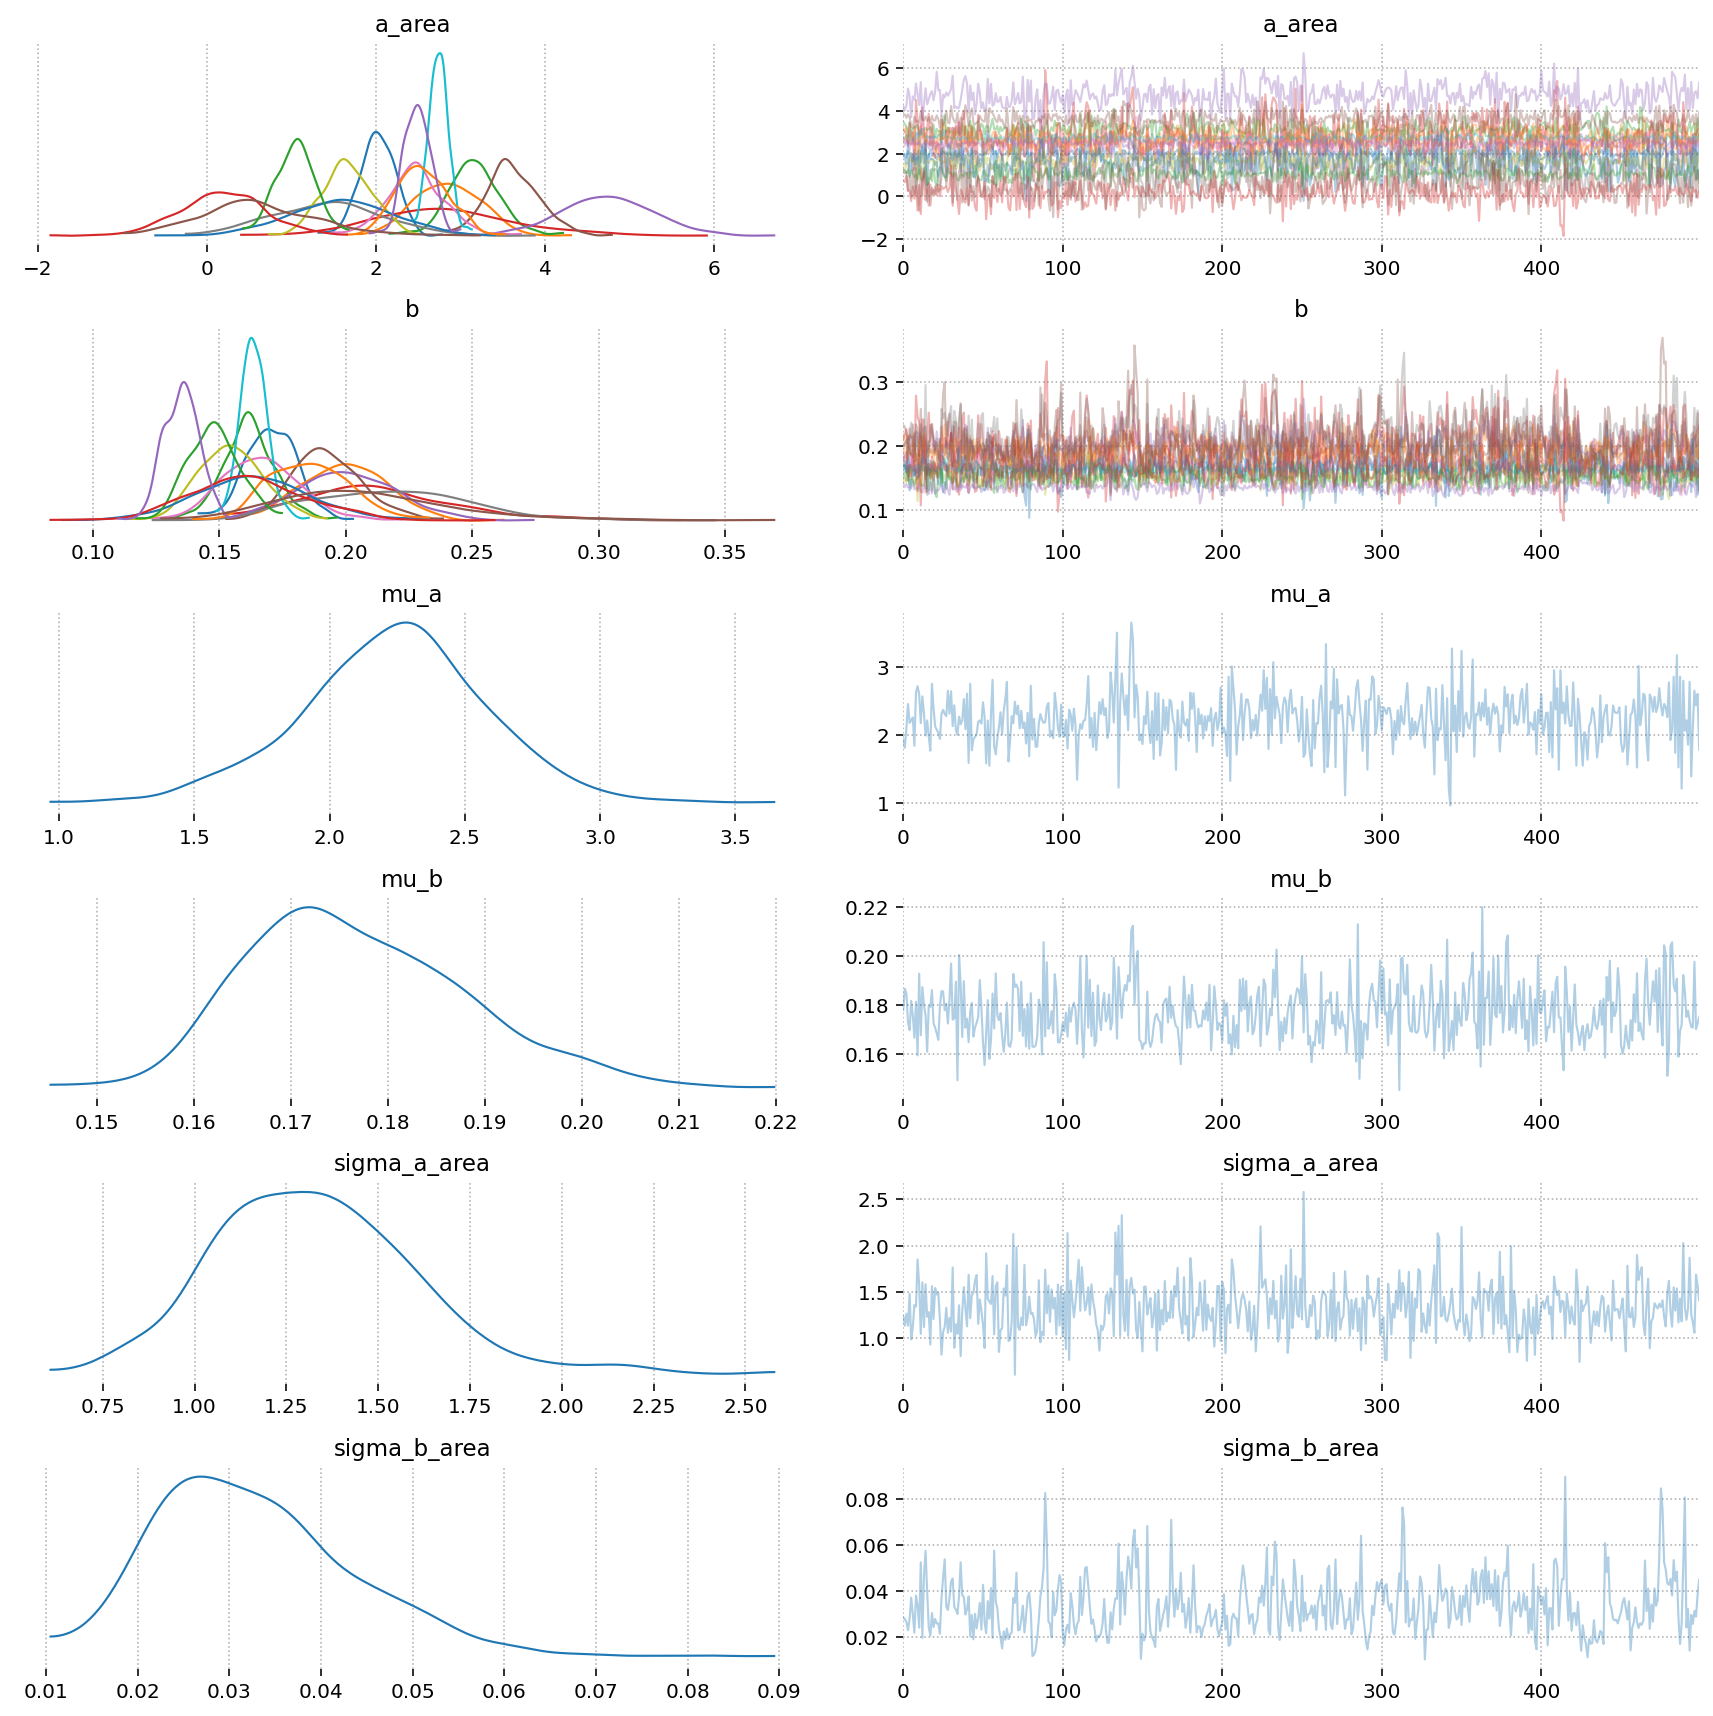

In [128]:
data = az.from_numpyro(mcmc)
az.plot_trace(data,compact=True)
plt.tight_layout()

In [129]:
mcmc_samples = mcmc.get_samples(group_by_chain=True)
mcmc_summary = numpyro.diagnostics.summary(mcmc_samples)

print(f"""
    Relatives tägliches Wachstum von Omikron gegenüber Delta:
    {np.exp(mcmc_summary['mu_b']['mean'])-1:.1%} mit 90%-Konfidenzintervall [{np.exp(mcmc_summary['mu_b']['5.0%'])-1:.1%}, {np.exp(mcmc_summary['mu_b']['95.0%'])-1:.1%}]
    Relative Verdopplungszeit von Omikron gegenüber Delta:
    {np.log(2)/np.log(1+mcmc_summary['mu_b']['mean']):.2} Tage mit 90%-Konfidenzintervall [{np.log(2)/np.log(1+mcmc_summary['mu_b']['95.0%']):.2},{np.log(2)/np.log(1+mcmc_summary['mu_b']['5.0%']):.2}]
    """)


    Relatives tägliches Wachstum von Omikron gegenüber Delta:
    19.4% mit 90%-Konfidenzintervall [17.3%, 21.7%]
    Relative Verdopplungszeit von Omikron gegenüber Delta:
    4.3 Tage mit 90%-Konfidenzintervall [3.9,4.7]
    


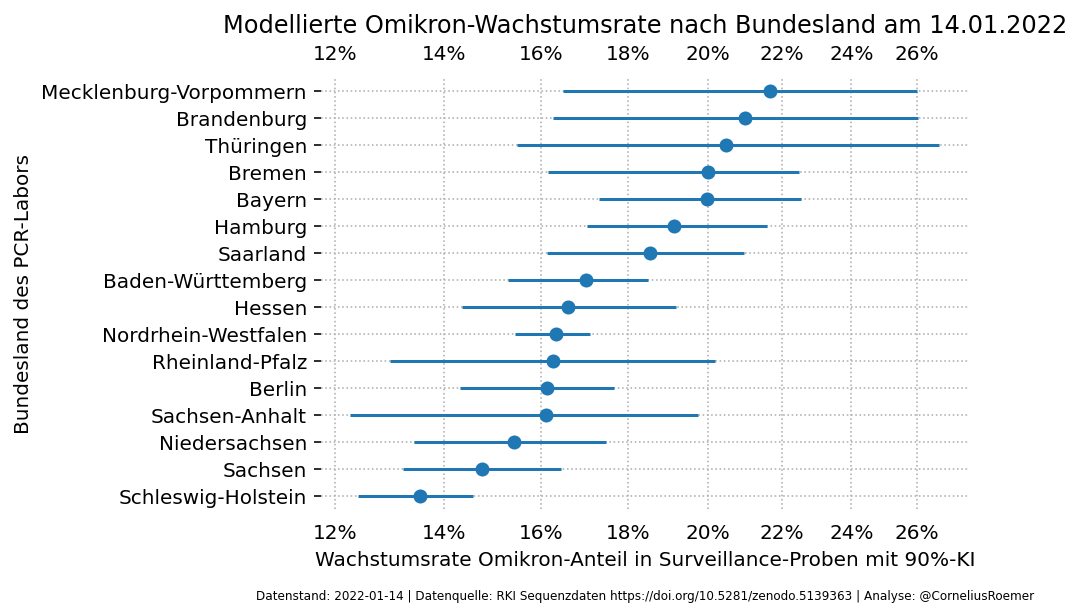

In [130]:
nice_formatter = ticker.FuncFormatter(
    lambda y, _: f'{ np.format_float_positional(100*y, trim="-", precision=6).rstrip(".")}%'
)
pdf = pd.DataFrame(mcmc_summary['b'], index=df_filtered.bundesland.values.categories)
pdf.sort_values(by='median',inplace=True)
errors = ([(pdf['median'])-(pdf['5.0%']),(pdf['95.0%'])-(pdf['median'])])
fig, ax = plt.subplots(figsize=(5,4)) 
#sns.set_theme(style="whitegrid")
ax.errorbar(x=(pdf['median'].values),y=pdf.index.values.astype(str),xerr=errors,linestyle='None',marker='o')
#sns.despine(left=True, bottom=True)
ax.set(title='Title')
ax.set_ylim(-0.5,len(pdf)-0.5)
ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set(title=f'Modellierte Omikron-Wachstumsrate nach Bundesland am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Bundesland des PCR-Labors")
ax.set_xlabel("Wachstumsrate Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15)
fig.text(0.5, -0.01, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
fig.savefig("plots/omi_share_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [131]:
list(df_filtered.bundesland.values.categories)

['Baden-Württemberg',
 'Bayern',
 'Berlin',
 'Brandenburg',
 'Bremen',
 'Hamburg',
 'Hessen',
 'Mecklenburg-Vorpommern',
 'Niedersachsen',
 'Nordrhein-Westfalen',
 'Rheinland-Pfalz',
 'Saarland',
 'Sachsen',
 'Sachsen-Anhalt',
 'Schleswig-Holstein',
 'Thüringen']

In [132]:
q = [0.05,0.5,0.95]
t = (np.arange("2021-11-20","2022-01-31", dtype='datetime64[D]') - np.datetime64("today")).astype("int")
prop_bl = pd.Series(expit(np.quantile(mcmc_samples['a_area'][0][...,np.newaxis] + mcmc_samples['b'][0][...,np.newaxis] * t[np.newaxis,np.newaxis,:], 
                                     q,
                                     axis = 0)).flatten(),
                         index = pd.MultiIndex.from_product([q, 
                                                             df_filtered.bundesland.values.categories,
                                                             np.datetime64("today") + t.astype("timedelta64[D]")],
                                                           names=['quantile',
                                                                  'bundesland',
                                                                  'date']),
                       )
prop_bl = prop_bl.reset_index().set_index(["bundesland","date","quantile"])#.pivot(columns="quantile")

In [133]:
prop_bl

0
bundesland        date       quantile          
Baden-Württemberg 2021-11-20 0.05      0.000348
                  2021-11-21 0.05      0.000418
                  2021-11-22 0.05      0.000500
                  2021-11-23 0.05      0.000601
                  2021-11-24 0.05      0.000723
...                                         ...
Thüringen         2022-01-26 0.95      0.994188
                  2022-01-27 0.95      0.995550
                  2022-01-28 0.95      0.996594
                  2022-01-29 0.95      0.997394
                  2022-01-30 0.95      0.998006

[3456 rows x 1 columns]

In [134]:
omi_bl

all  omi  days  sending_area  sending_pc_ID  \
bundesland        date                                                      
Baden-Württemberg 2021-11-20  119    0  -660            84            972   
                  2021-11-21   92    0  -648            84            972   
                  2021-11-22  534    0  -636            84            972   
                  2021-11-23  112    0  -624            84            972   
                  2021-11-24   46    0  -612            84            972   
...                           ...  ...   ...           ...            ...   
Thüringen         2022-01-06    0    0   -32            27            312   
                  2022-01-07    0    0   -28            27            312   
                  2022-01-08    0    0   -24            27            312   
                  2022-01-09    0    0   -20            27            312   
                  2022-01-10    0    0   -16            27            312   

                              prop  
bundesland        date              
Baden-Württemberg 2021-11-20   0.0  
                  2021-11-21   0.0  
                  2021-11-22   0.0  
                  2021-11-23   0.0  
                  2021-11-24   0.0  
...                            ...  
Thüringen         2022-01-06   NaN  
                  2022-01-07   NaN  
                  2022-01-08   NaN  
                  2022-01-09   NaN  
                  2022-01-10   NaN  

[832 rows x 6 columns]

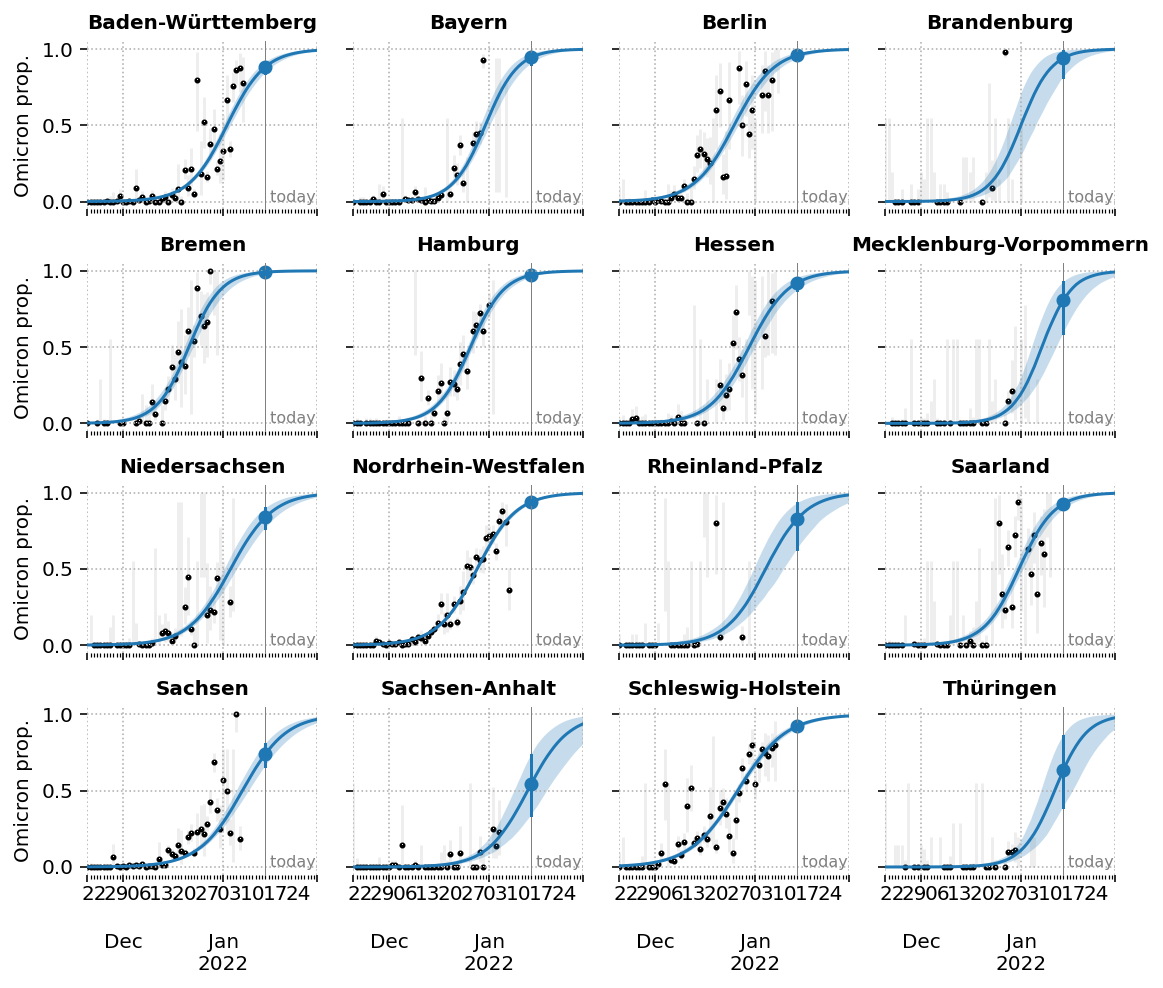

In [135]:
#sns.reset_orig()
plt.rcParams['figure.facecolor'] = 'white'
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(prop_bl.index.levels[0]):
    prop_bl.loc[r,:,0.5][0].plot(label=r, ax=ax[i])
    ax[i].fill_between(prop_bl.loc[r,:,0.05][0].index, prop_bl.loc[r,:,0.05][0], prop_bl.loc[r,:,0.95][0], alpha=0.25)
    ax[i].axvline(np.datetime64("today"), color='grey', lw=0.5)
    ax[i].text(np.datetime64("today"),0.0, " today", size=8, color='grey')
    ax[i].plot(np.repeat(np.datetime64("today"),2), prop_bl.loc[r,np.datetime64("today"),[0.05,0.95]], c='C0')
    ax[i].scatter(np.datetime64("today"), prop_bl.loc[r,np.datetime64("today"),0.5], c='C0')
    ax[i].grid(ls=":")
    import scipy.stats as sps
    ci = sps.beta(omi_bl.loc[r]['omi'].values.reshape(-1,1) + .1,  omi_bl.loc[r]['all'].values.reshape(-1,1) - omi_bl.loc[r]['omi'].values.reshape(-1,1) + .1).isf(np.array([0.95,0.05]).reshape(1,-1))
    ax[i].errorbar(omi_bl.loc[r].index, omi_bl.loc[r]['prop'], yerr=np.abs(ci - omi_bl.loc[r]['prop'].values.reshape(-1,1) ).T, ls="", marker=",", color='#EEEEEE', zorder=0)
    omi_bl.loc[r]['prop'][omi_bl.loc[r]['all']>=5].plot(ls="", marker=".", markersize=4, label=r, ax=ax[i], c='black', zorder=0)
    ax[i].set_title(r, size=10, weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Omicron prop.")

    for a in ax[i].spines.values():
        a.set_visible(False)
plt.tight_layout()
fig.savefig("plots/omi_share_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

Text(0.5, -0.01, 'Datenstand: 2022-01-14 | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer')

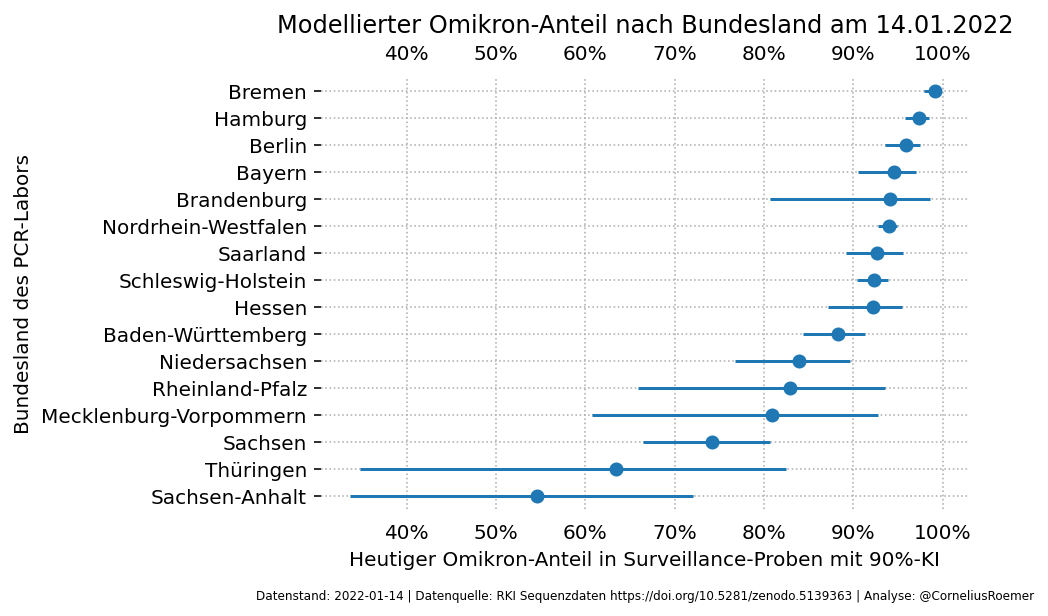

In [136]:
pdf = pd.DataFrame(mcmc_summary['a_area'], index=df_filtered.bundesland.values.categories)
pdf.sort_values(by='median',inplace=True)
errors = ([expit(pdf['median'])-expit(pdf['5.0%']),expit(pdf['95.0%'])-expit(pdf['median'])])
fig, ax = plt.subplots(figsize=(5,4)) 
#sns.set_theme(style="whitegrid")
ax.errorbar(x=expit(pdf['median'].values),y=pdf.index.values.astype(str),xerr=errors,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax.set(title='Title')
ax.set_ylim(-0.5,len(pdf)-0.5)
#ax.set_xscale('logit')
ax.xaxis.set_major_formatter(nice_formatter)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set(title=f'Modellierter Omikron-Anteil nach Bundesland am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Bundesland des PCR-Labors")
ax.set_xlabel("Heutiger Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15)
fig.text(0.5, -0.01, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
#fig.savefig("plots/omi_share_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

## Maps
Map postcodes to Bundesländer (~5 Minutes)

In [90]:
bl = plz.dissolve(by = 'bundesland')
bl.geometry = bl.simplify(1e-2, preserve_topology=False)

In [91]:
bl['land'] = "Deutschland"

In [92]:
bl

geometry  \
bundesland                                                                  
#N/A                    POLYGON ((6.83623 49.21127, 6.85915 49.22275, ...   
Baden-Württemberg       MULTIPOLYGON (((7.63396 47.56122, 7.68592 47.5...   
Bayern                  MULTIPOLYGON (((9.63623 47.60202, 9.74582 47.6...   
Berlin                  POLYGON ((13.73143 52.41981, 13.73412 52.40198...   
Brandenburg             POLYGON ((14.03274 51.47500, 14.06259 51.44542...   
Bremen                  MULTIPOLYGON (((8.96595 53.05772, 8.98022 53.0...   
Hamburg                 MULTIPOLYGON (((10.21828 53.49923, 10.26573 53...   
Hessen                  MULTIPOLYGON (((8.90009 49.48187, 8.89974 49.5...   
Mecklenburg-Vorpommern  MULTIPOLYGON (((11.52874 54.07105, 11.51283 54...   
Niedersachsen           MULTIPOLYGON (((10.36397 51.55606, 10.36689 51...   
Nordrhein-Westfalen     MULTIPOLYGON (((6.16603 50.66186, 6.19337 50.6...   
Rheinland-Pfalz         POLYGON ((8.28766 48.99838, 8.23545 48.96749, ...   
Saarland                POLYGON ((7.31027 49.12958, 7.29356 49.11499, ...   
Sachsen                 POLYGON ((12.23908 50.24698, 12.26616 50.25888...   
Sachsen-Anhalt          POLYGON ((12.19559 51.14146, 12.24134 51.13061...   
Schleswig-Holstein      MULTIPOLYGON (((11.00454 54.45007, 11.01815 54...   
Thüringen               POLYGON ((10.59094 50.27180, 10.60497 50.29310...   

                        OBJECTID    plz       ags                ort  \
bundesland                                                             
#N/A                         409  57540      #N/A               #N/A   
Baden-Württemberg           1129  79588  08336014   Efringen-Kirchen   
Bayern                      3150  63791  09671114  Karlstein am Main   
Berlin                      8042  14109  11000000             Berlin   
Brandenburg                 6380  19309  12070236               Lanz   
Bremen                      2400  28777  04011000             Bremen   
Hamburg                     2308  27499  02000000            Hamburg   
Hessen                      1486  65391  06439010              Lorch   
Mecklenburg-Vorpommern      5574  19258  13076009        Bengerstorf   
Niedersachsen                253  26757  03457002             Borkum   
Nordrhein-Westfalen            1  52538  05370008            Gangelt   
Rheinland-Pfalz               24  54689  07232001             Affler   
Saarland                      92  66706  10042115               Perl   
Sachsen                     7046  08538  14523450         Weischlitz   
Sachsen-Anhalt              5540  38835  15085230         Osterwieck   
Schleswig-Holstein          1625  27498  01056025          Helgoland   
Thüringen                   4517  36419  16063011            Buttlar   

                                            landkreis  einwohner  \
bundesland                                                         
#N/A                                             #N/A        0.0   
Baden-Württemberg                   Landkreis Lörrach     8205.0   
Bayern                        Landkreis Aschaffenburg     8023.0   
Berlin                                           None    10049.0   
Brandenburg                        Landkreis Prignitz     3684.0   
Bremen                                           None    12969.0   
Hamburg                                          None        8.0   
Hessen                          Rheingau-Taunus-Kreis     3994.0   
Mecklenburg-Vorpommern  Landkreis Ludwigslust-Parchim    15989.0   
Niedersachsen                          Landkreis Leer     5207.0   
Nordrhein-Westfalen                   Kreis Heinsberg    21390.0   
Rheinland-Pfalz               Eifelkreis Bitburg-Prüm     2326.0   
Saarland                      Landkreis Merzig-Wadern     7791.0   
Sachsen                                 Vogtlandkreis     6264.0   
Sachsen-Anhalt                         Landkreis Harz    10404.0   
Schleswig-Holstein                    Kreis Pinneberg     1407.0   
Thüringe

In [137]:
de = bl.copy()
de.geometry = de.buffer(1e-2)
de = de.dissolve(by='land')

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


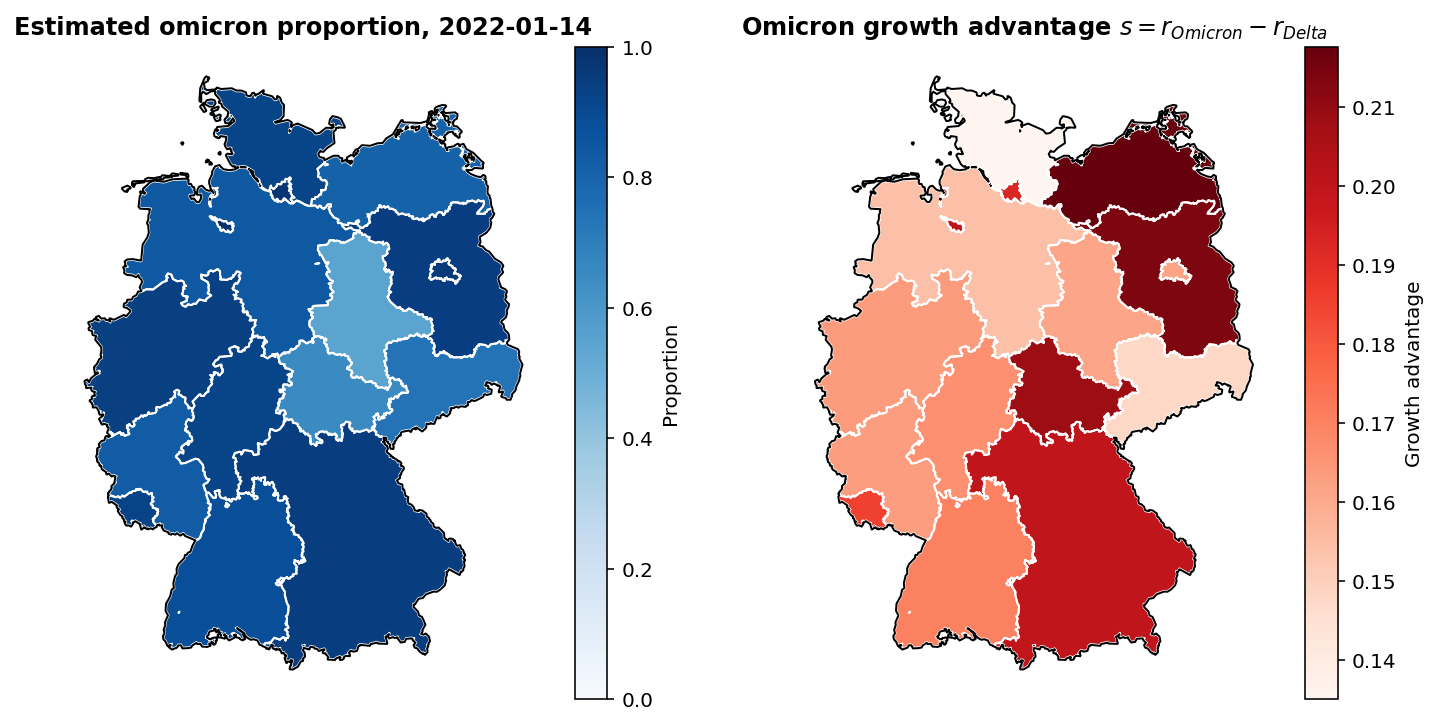

In [138]:
#sns.set_style("white")
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax = ax.flatten()
#sns.reset_orig()
plt.rcParams['figure.facecolor'] = 'white'
pdf = pd.DataFrame({'prop':expit(mcmc_summary['a_area']['mean']),
                    'prop_5%':expit(mcmc_summary['a_area']['5.0%']),
                    'prop_95%':expit(mcmc_summary['a_area']['95.0%']),
                    's': mcmc_summary['b']['mean'],
                    's_sd': mcmc_summary['b']['std']},
                   index=df_filtered.bundesland.values.categories)

b = bl.merge(pdf, left_index=True, right_index=True)
b.plot("prop", lw=1, cmap="Blues", 
            legend=True,
            legend_kwds={'label': "Proportion"},
            figsize=(6,6),
            ax = ax[0],
            vmin = 0,
           vmax = 1
           )
#bl_diag = bl.copy().intersection(diag).rename("geometry").to_frame().merge(pdf, left_index=True, right_index=True)
#bl_diag.plot("prop_95%", lw=1, cmap="Blues", ax=plt.gca())


b.boundary.plot(color='w',lw=1, ax=ax[0])
de.boundary.plot(color='k',lw=1, ax=ax[0])

ax[0].axis('off')
ax[0].set_title(f"Estimated omicron proportion, {np.datetime64('today')}", weight='bold')

b.plot("s", lw=1, cmap="Reds", 
            legend=True,
            legend_kwds={'label': "Growth advantage"},
            figsize=(6,6),
       ax = ax[1]
           )
b.boundary.plot(color='w',lw=1, ax=ax[1])
de.boundary.plot(color='k',lw=1,  ax=ax[1])

ax[1].axis('off')
ax[1].set_title("Omicron growth advantage $s = r_{Omicron} - r_{Delta}$", weight='bold')
fig.savefig("plots/omi_share_map.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [139]:
bar = omi_bl.reset_index()
bar['week'] = bar.date - pd.to_timedelta(bar.date.dt.dayofweek, unit='d')
bar = bar.set_index(['bundesland', 'week','date']).sum(level=(0,1))
bar['prop'] = bar.omi/bar['all']
bar['prop']

bundesland         week      
Baden-Württemberg  2021-11-15    0.000000
                   2021-11-22    0.000652
                   2021-11-29    0.006645
                   2021-12-06    0.009434
                   2021-12-13    0.018106
                                   ...   
Thüringen          2021-12-13    0.000000
                   2021-12-20    0.000000
                   2021-12-27    0.092784
                   2022-01-03    0.000000
                   2022-01-10         NaN
Name: prop, Length: 144, dtype: float64

(2707.0, 2716.0)

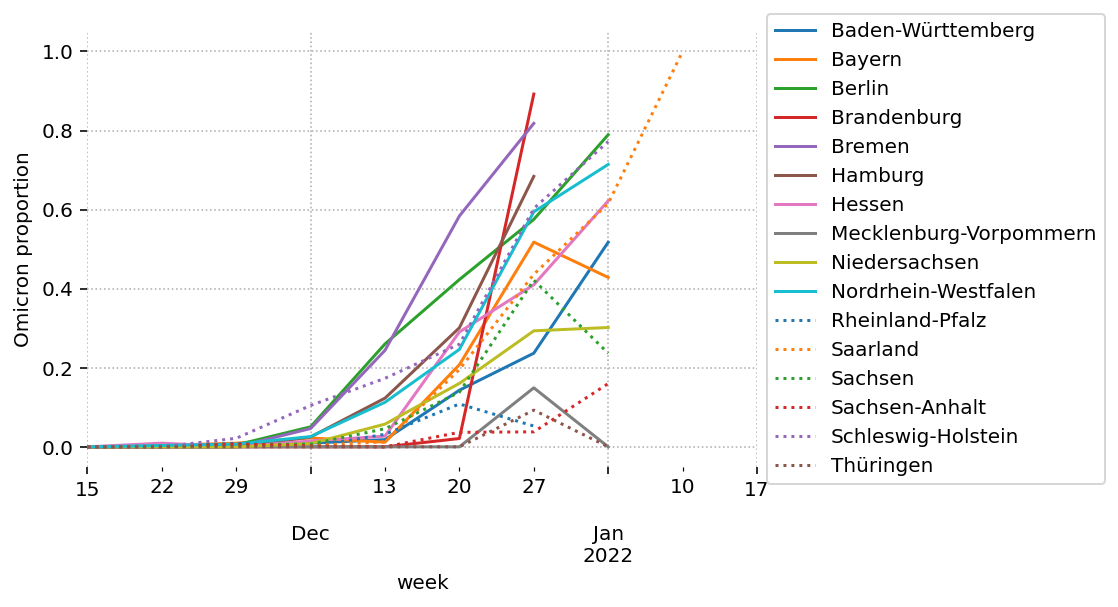

In [140]:
for i,r in enumerate(bar.index.levels[0]):
    bar.loc[r]['prop'].plot( label=r, ls = "-" if i <10 else ":")
#foo.mean(level=1)['prop'].plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel("Omicron proportion")
plt.xlim((None,np.datetime64("today")))

In [141]:
bar.loc[:,'2021-12-20':,:]

all  omi  days  sending_area  sending_pc_ID  \
bundesland         week                                                      
Baden-Württemberg  2021-12-20  405   58 -1848           588           6804   
                   2021-12-27  684  162 -1260           588           6804   
                   2022-01-03  342  177  -672           588           6804   
                   2022-01-10    0    0   -48            84            972   
Bayern             2021-12-20  467   97 -1848           714           7728   
...                            ...  ...   ...           ...            ...   
Schleswig-Holstein 2022-01-10    0    0   -16             8            125   
Thüringen          2021-12-20  166    0  -616           189           2184   
                   2021-12-27  194   18  -420           189           2184   
                   2022-01-03    6    0  -224           189           2184   
                   2022-01-10    0    0   -16            27            312   

                                   prop  
bundesland         week                  
Baden-Württemberg  2021-12-20  0.143210  
                   2021-12-27  0.236842  
                   2022-01-03  0.517544  
                   2022-01-10       NaN  
Bayern             2021-12-20  0.207709  
...                                 ...  
Schleswig-Holstein 2022-01-10       NaN  
Thüringen          2021-12-20  0.000000  
                   2021-12-27  0.092784  
                   2022-01-03  0.000000  
                   2022-01-10       NaN  

[64 rows x 6 columns]

In [98]:
cases = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [99]:
cases = cases['AnzahlFall'].sum(level=(0,3)).sort_index()

In [100]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [101]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land

AnzahlFall
bundesland        Refdatum              
Baden-Württemberg 2020-01-05           1
                  2020-01-06           2
                  2020-01-07           1
                  2020-01-12           1
                  2020-01-24           1
...                                  ...
Thüringen         2022-01-09         487
                  2022-01-10         435
                  2022-01-11         573
                  2022-01-12         399
                  2022-01-13         360

[11194 rows x 1 columns]

Text(0, 0.5, 'cases')

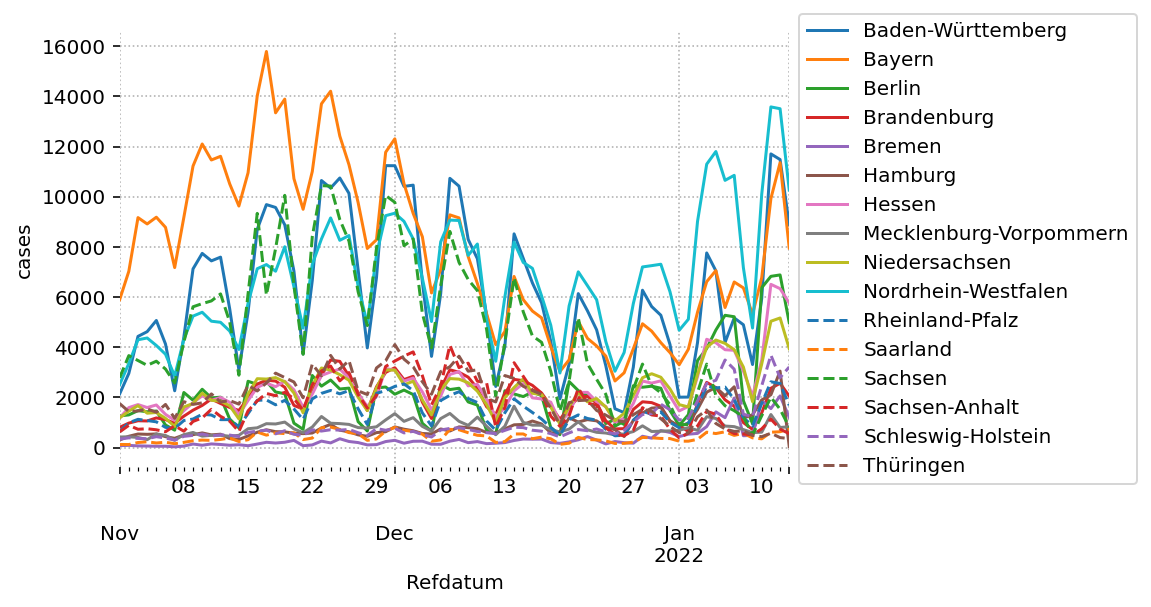

In [102]:
for i,r in enumerate(cases_land.index.levels[0]):
    cases_land.loc[r].loc["2021-11-01":,'AnzahlFall'].plot(label=r, ls="-" if i<10 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel('cases')
#plt.xlim("")

In [103]:
bar

all  omi  days  sending_area  sending_pc_ID  \
bundesland        week                                                       
Baden-Württemberg 2021-11-15   211    0 -1308           168           1944   
                  2021-11-22  1533    1 -4200           588           6804   
                  2021-11-29   903    6 -3612           588           6804   
                  2021-12-06   954    9 -3024           588           6804   
                  2021-12-13   718   13 -2436           588           6804   
...                            ...  ...   ...           ...            ...   
Thüringen         2021-12-13   240    0  -812           189           2184   
                  2021-12-20   166    0  -616           189           2184   
                  2021-12-27   194   18  -420           189           2184   
                  2022-01-03     6    0  -224           189           2184   
                  2022-01-10     0    0   -16            27            312   

                                  prop  
bundesland        week                  
Baden-Württemberg 2021-11-15  0.000000  
                  2021-11-22  0.000652  
                  2021-11-29  0.006645  
                  2021-12-06  0.009434  
                  2021-12-13  0.018106  
...                                ...  
Thüringen         2021-12-13  0.000000  
                  2021-12-20  0.000000  
                  2021-12-27  0.092784  
                  2022-01-03  0.000000  
                  2022-01-10       NaN  

[144 rows x 6 columns]

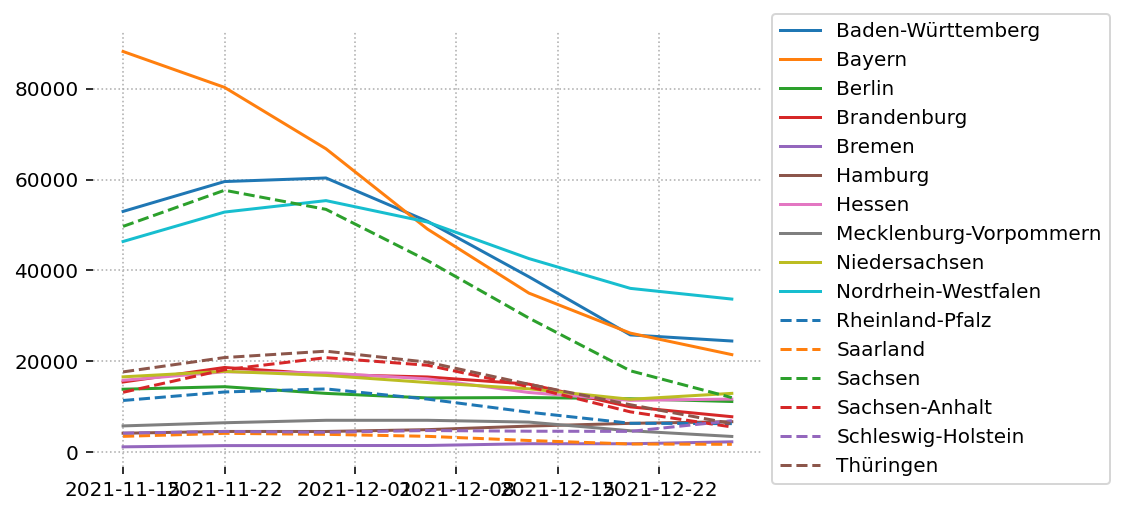

In [104]:
for i,r in enumerate(cases_land.index.levels[0]):
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum - pd.to_timedelta(c.Refdatum.dt.dayofweek, unit='d') 
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[r], left_index=True, right_index=True)
    plt.plot(c.index, c['AnzahlFall'] , label=r, ls="-" if i < 10 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

Text(0, 0.5, 'Omicron cases')

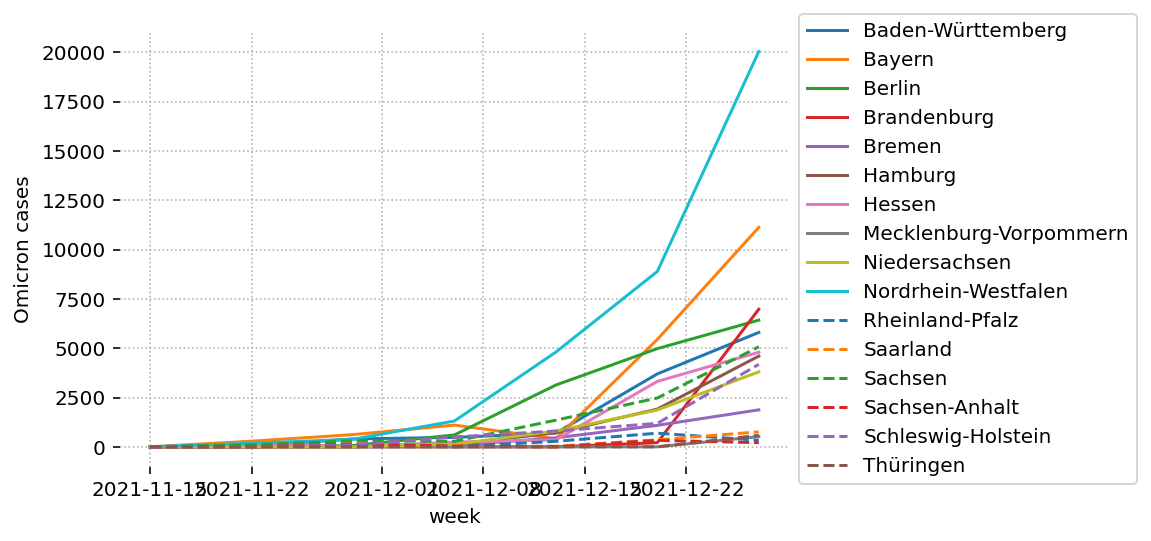

In [105]:
for i,r in enumerate(cases_land.index.levels[0]):
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum - pd.to_timedelta(c.Refdatum.dt.dayofweek, unit='d') 
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[r], left_index=True, right_index=True)
    plt.plot(c.index, c['AnzahlFall'] * c['prop'], label=r, ls="-" if i < 10 else "--")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel('week')
plt.ylabel("Omicron cases")

In [106]:
bar

all  omi  days  sending_area  sending_pc_ID  \
bundesland        week                                                       
Baden-Württemberg 2021-11-15   211    0 -1308           168           1944   
                  2021-11-22  1533    1 -4200           588           6804   
                  2021-11-29   903    6 -3612           588           6804   
                  2021-12-06   954    9 -3024           588           6804   
                  2021-12-13   718   13 -2436           588           6804   
...                            ...  ...   ...           ...            ...   
Thüringen         2021-12-13   240    0  -812           189           2184   
                  2021-12-20   166    0  -616           189           2184   
                  2021-12-27   194   18  -420           189           2184   
                  2022-01-03     6    0  -224           189           2184   
                  2022-01-10     0    0   -16            27            312   

                                  prop  
bundesland        week                  
Baden-Württemberg 2021-11-15  0.000000  
                  2021-11-22  0.000652  
                  2021-11-29  0.006645  
                  2021-12-06  0.009434  
                  2021-12-13  0.018106  
...                                ...  
Thüringen         2021-12-13  0.000000  
                  2021-12-20  0.000000  
                  2021-12-27  0.092784  
                  2022-01-03  0.000000  
                  2022-01-10       NaN  

[144 rows x 6 columns]

In [107]:
cases_land

AnzahlFall
bundesland        Refdatum              
Baden-Württemberg 2020-01-05           1
                  2020-01-06           2
                  2020-01-07           1
                  2020-01-12           1
                  2020-01-24           1
...                                  ...
Thüringen         2022-01-09         487
                  2022-01-10         435
                  2022-01-11         573
                  2022-01-12         399
                  2022-01-13         360

[11194 rows x 1 columns]

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


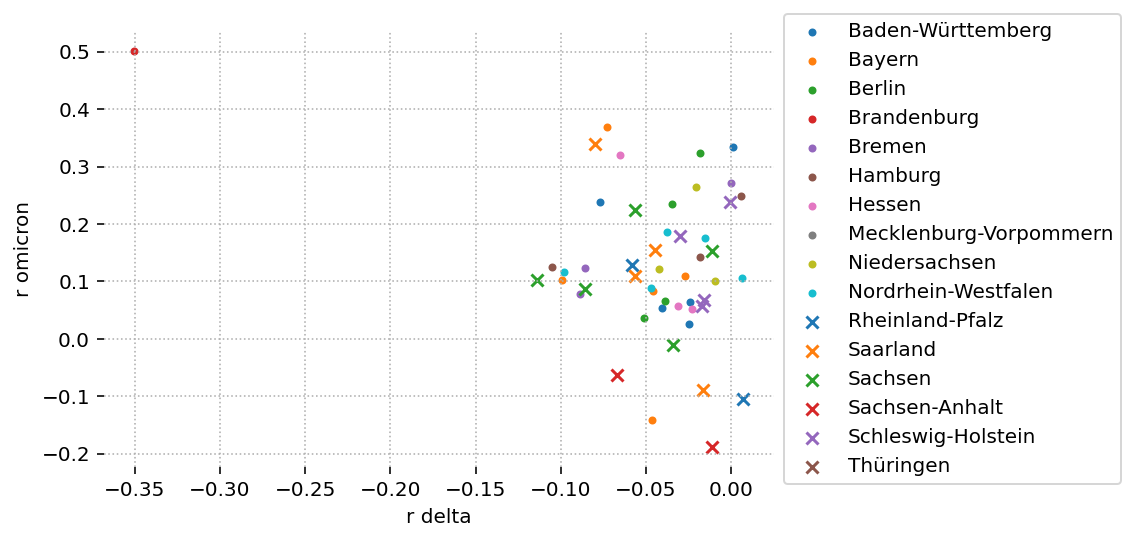

In [108]:
for i,r in enumerate(cases_land.index.levels[0]):
    c = cases_land.loc[r,"2021-11-01":"2021-12-31",:].reset_index()
    c['week'] = c.Refdatum - pd.to_timedelta(c.Refdatum.dt.dayofweek, unit='d') 
    c = c.set_index(['week','Refdatum']).sum(level=0).merge(bar.loc[r], left_index=True, right_index=True)
    y = c['AnzahlFall'] * c['prop']
    x = c['AnzahlFall'] * (1-c['prop'])
    dx = np.log(x[1:]/x[:-1].values)/7
    dy = np.log(y[1:]/y[:-1].values)/7
    plt.scatter(dx, dy, label=r, marker = "." if i <10 else "x")
plt.xlabel("r delta")
plt.ylabel("r omicron")
    
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [142]:
c = cases_land.loc[:,"2021-12-08":"2021-12-21",:] / cases_land.loc[:,"2021-12-01":"2021-12-14",:].values
foo = np.log(c).mean(level=0).rename(columns={'AnzahlFall':'r'}) / 7
foo['r_sd'] = np.log(c).std(level=0).values / 7

In [143]:
foo = foo.merge(pdf, left_index=True, right_index=True)

<AxesSubplot:xlabel='r', ylabel='s'>

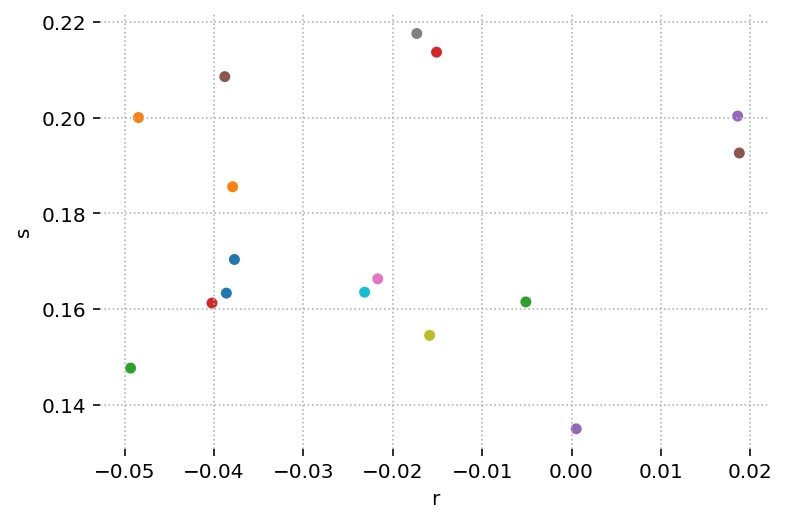

In [144]:
foo.plot.scatter("r","s", c = [f'C{i}' for i in range(foo.shape[0])])
#plt.legend()

Text(0, 0.5, 'Growth rate Omicron')

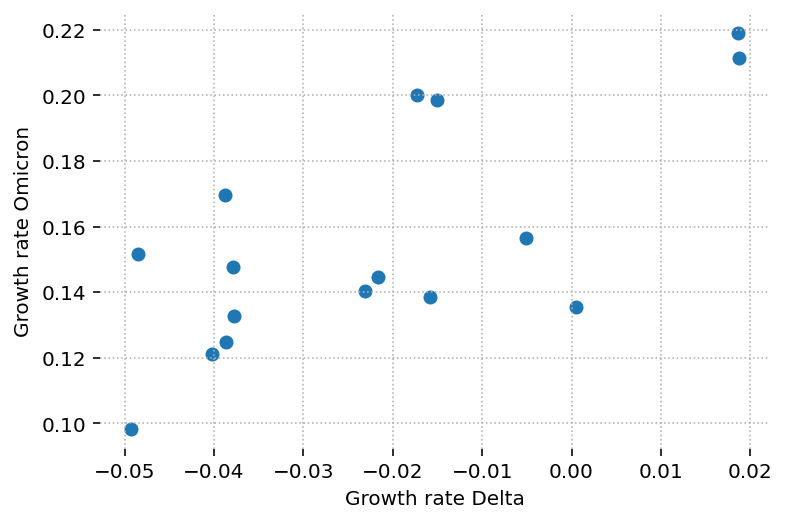

In [145]:
plt.scatter(foo['r'], foo['s'] + foo['r'])
plt.xlabel("Growth rate Delta")
plt.ylabel("Growth rate Omicron")

In [146]:
foo.to_csv(f"Germany_SGTF_{np.datetime64('today')}.csv")

In [147]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [148]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

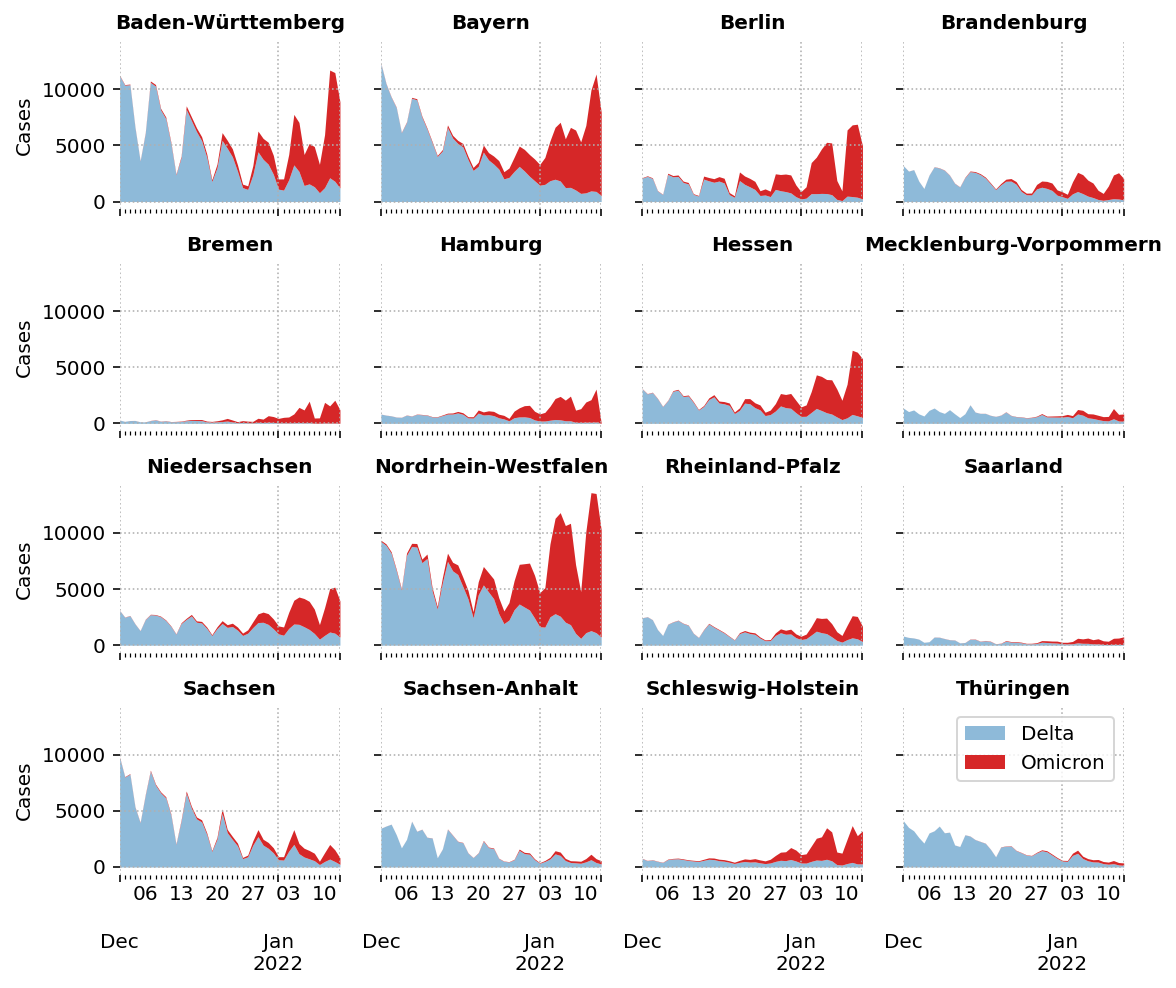

In [149]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(prop_bl.index.levels[0]):
    y = cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] 
    y.index.name = 'date'
    x = prop_bl.loc[r,:,:][0].unstack()
    z = ((1-x[0.5]) * y)
    s = pd.Series(np.exp(lowess(np.log(z), z.index)[:,1]), z.dropna().index)
    y.plot(ax=ax[i], ls="", label="")
    ax[i].fill_between(z.index, y-x[0.5]*y, color='C0', alpha=.5, lw=0, label="Delta")
    ax[i].fill_between(z.index, y-x[0.5]*y, y-x[0.05]+x[0.05], color='C3', lw=0, label="Omicron")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    #ax[i].plot(s.index, s, ls="-", c='C0')
    #s.iloc[-7:-1]
    #ax[i].plot(x.index, s/(1-x[0.5]), ls="-", c='C3')
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases")
    ax[i].grid(ls=":")
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()

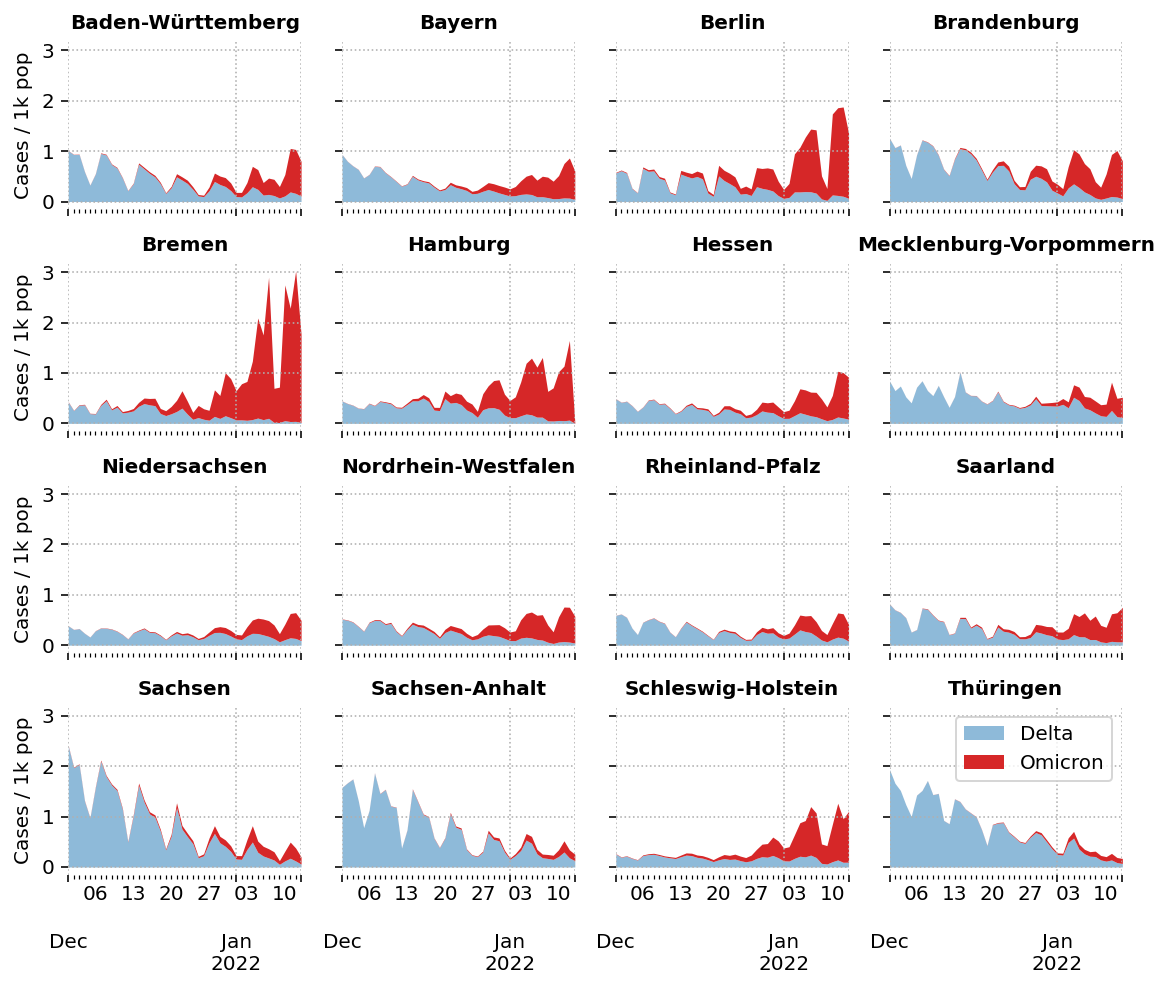

In [150]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(prop_bl.index.levels[0]):
    y = cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000
    y.index.name = 'date'
    x = prop_bl.loc[r,:,:][0].unstack()
    z = x[0.5] * y
    y.plot(ax=ax[i], ls="", label="")
    ax[i].fill_between(z.index, y-x[0.5]*y, color='C0', alpha=.5, lw=0, label="Delta")
    ax[i].fill_between(z.index, y-x[0.5]*y, y-x[0.05]+x[0.05], color='C3', lw=0, label="Omicron")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 1k pop")
    ax[i].grid(ls=":")
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()
fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

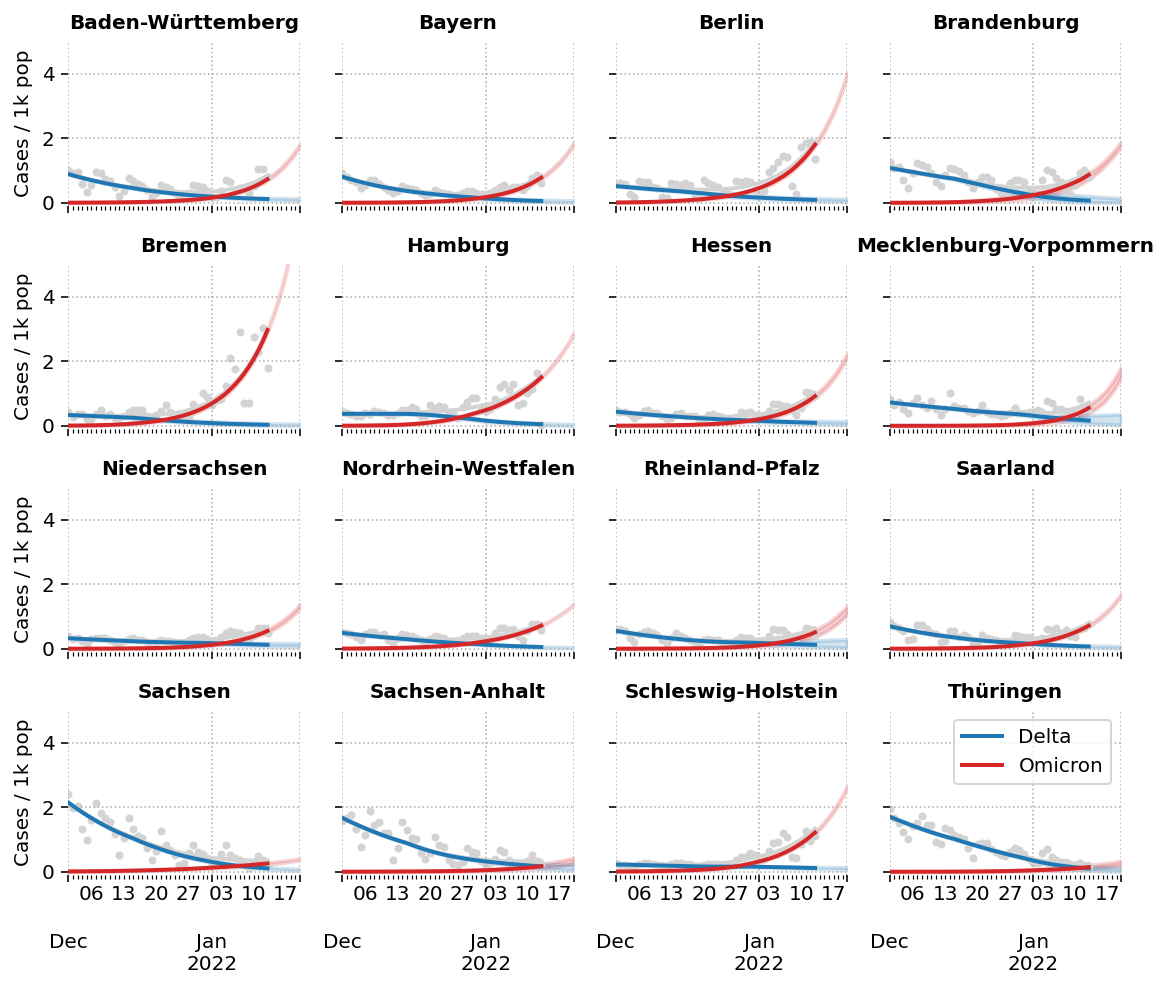

In [151]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
e = {}
f = {}
for i,r in enumerate(prop_bl.index.levels[0]):
    y = cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000
    y.index.name = 'date'
    x = prop_bl.loc[r,:,:][0].unstack()
    z = ((1-x[0.5]) * y)
    s = pd.Series(np.exp(lowess(np.log(z), z.index)[:,1]), z.dropna().index)
    y.plot(ax=ax[i], ls="", label="")
    #ax[i].fill_between(s.index, s, color='C0', alpha=.5, lw=0, label="Delta")
    #ax[i].fill_between(x.index, s*x[0.5]/x[0.5], s/(1-x[0.5]), color='C3', lw=0, label="Omicron")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].plot(x.index, s/(1-x[0.5]), ls="-", c='lightgrey', label="", lw=2)
    ax[i].plot(s.index, s, ls="-", c='C0', label="Delta", lw=2)
    ax[i].plot(x.index, s/(1-x[0.5]) * x[.5], ls="-", c='C3', label="Omicron", lw=2)
    
    s1 = pd.Series(np.exp(np.log(s).diff().iloc[-7:].mean() * np.arange(1,8) + np.log(s)[-1]), index=s.index[-1] + np.arange(1,8).astype("timedelta64[D]"))
    #ax[i].plot(x.index, s1/(1-x[0.5]), ls=":", c='lightgrey', label="", lw=2)
    #ax[i].plot(s1.index, s1, ls=":", c='C0', label="", lw=2)
    #ax[i].plot(x.index, s1/(1-x[0.5]) * x[.5], ls=":", c='C3', label="", lw=2)
    
    s = pd.concat([s,s1])
    ax[i].fill_between(x.index, s/(1-x[0.5]) * x[0.05] , s/(1-x[0.5]) * x[0.95], color='C3', lw=2, alpha=0.2)
    ax[i].fill_between(x.index, s/(1-x[0.5]) * (1-x[0.05]) , s/(1-x[0.5]) * (1-x[0.95]) , color='C0', lw=2, alpha=0.2)

    
    ax[i].scatter(y.index, y, marker=".",c='lightgrey', label="")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 1k pop")
    ax[i].grid(ls=":")
    ax[i].set_xlim((None, s1.index[-1]))
    ax[i].set_ylim((None, 5))
    for a in ax[i].spines.values():
        a.set_visible(False)
    e[r] = s/(1-x[0.5][s.index]) * capita[r] / 1000
    f[r] = s * capita[r] / 1000
ax[-1].legend(title=None)
plt.tight_layout()
fig.savefig("plots/omi_abs_by_area_fit.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

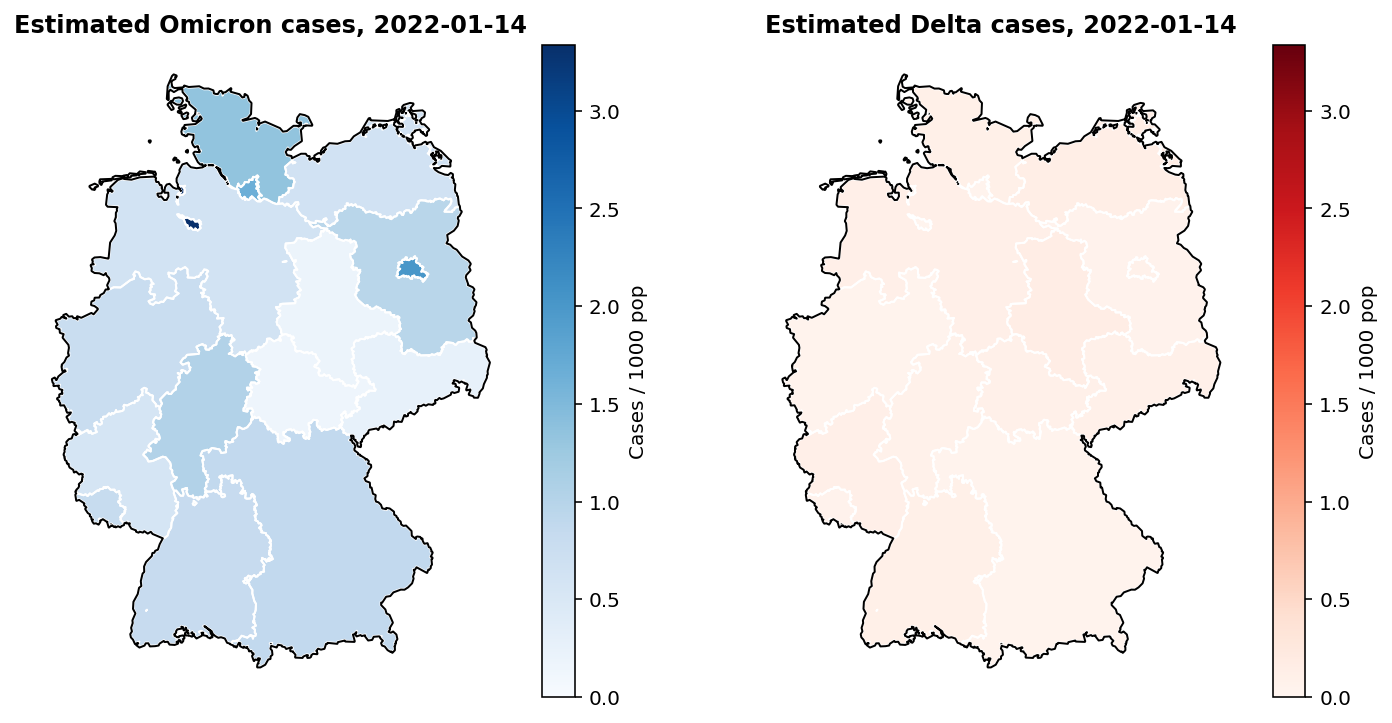

In [152]:
d = pd.DataFrame(f).loc[np.datetime64("today")] / capita * 1000
o = pd.DataFrame(e).loc[np.datetime64("today")] / capita * 1000 - d

y = pd.DataFrame({'Omicron':o, 'Delta':d})

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax = ax.flatten()
#sns.reset_orig()
plt.rcParams['figure.facecolor'] = 'white'

b = bl.merge(y, left_index=True, right_index=True)
b.plot("Omicron", lw=1, cmap="Blues", 
            legend=True,
            legend_kwds={'label': "Cases / 1000 pop"},
            figsize=(6,6),
            ax = ax[0],
       vmin = 0,
       vmax = y.max().max()
           )
#bl_diag = bl.copy().intersection(diag).rename("geometry").to_frame().merge(pdf, left_index=True, right_index=True)
#bl_diag.plot("prop_95%", lw=1, cmap="Blues", ax=plt.gca())


b.boundary.plot(color='w',lw=1, ax=ax[0])
de.boundary.plot(color='k',lw=1, ax=ax[0])

ax[0].axis('off')
ax[0].set_title(f"Estimated Omicron cases, {np.datetime64('today')}", weight='bold')

b.plot("Delta", lw=1, cmap="Reds", 
            legend=True,
            legend_kwds={'label': "Cases / 1000 pop"},
            figsize=(6,6),
       ax = ax[1],
              vmin = 0,
       vmax = y.max().max()
           )
b.boundary.plot(color='w',lw=1, ax=ax[1])
de.boundary.plot(color='k',lw=1,  ax=ax[1])

ax[1].axis('off')
ax[1].set_title(f"Estimated Delta cases, {np.datetime64('today')}", weight='bold')
fig.savefig("plots/omi_share_map.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

<AxesSubplot:title={'center':'Estimated Omicron growth rate $r$'}>

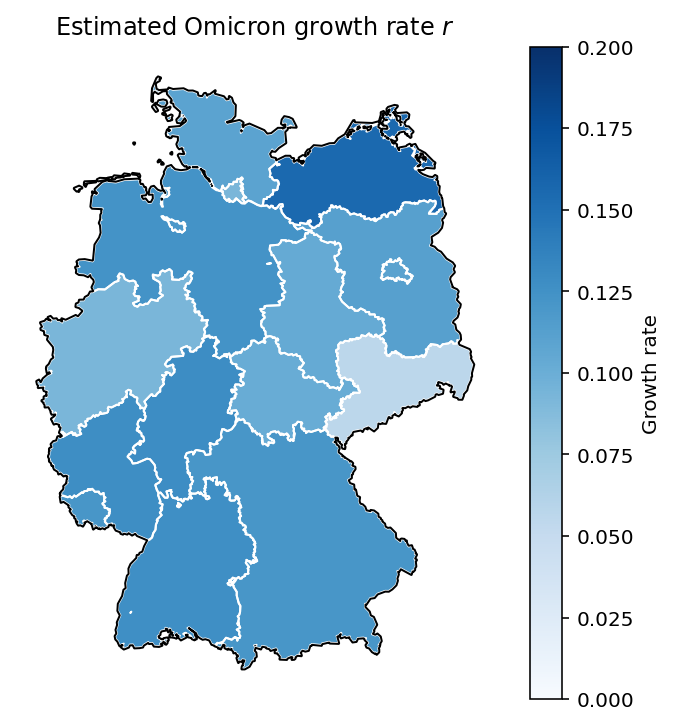

In [153]:
r = np.log(pd.DataFrame(e) - pd.DataFrame(f)).diff()

fig, ax = plt.subplots(1,1, figsize=(6,6))

r = bl.merge(r.loc[np.datetime64("today"),:], left_index=True, right_index=True)
r.plot(r.columns[-1], lw=1, cmap="Blues", 
            legend=True,
            legend_kwds={'label': "Growth rate"},
            figsize=(6,6),
            ax = ax,
       vmin = 0,
       vmax = 0.2,#y.max().max()
           )
#bl_diag = bl.copy().intersection(diag).rename("geometry").to_frame().merge(pdf, left_index=True, right_index=True)
#bl_diag.plot("prop_95%", lw=1, cmap="Blues", ax=plt.gca())
ax.set_title( "Estimated Omicron growth rate $r$")

ax.axis("off")
b.boundary.plot(color='w',lw=1, ax=ax)
de.boundary.plot(color='k',lw=1, ax=ax)

<AxesSubplot:title={'center':'Germany'}, xlabel='date', ylabel='Omicron proportion'>

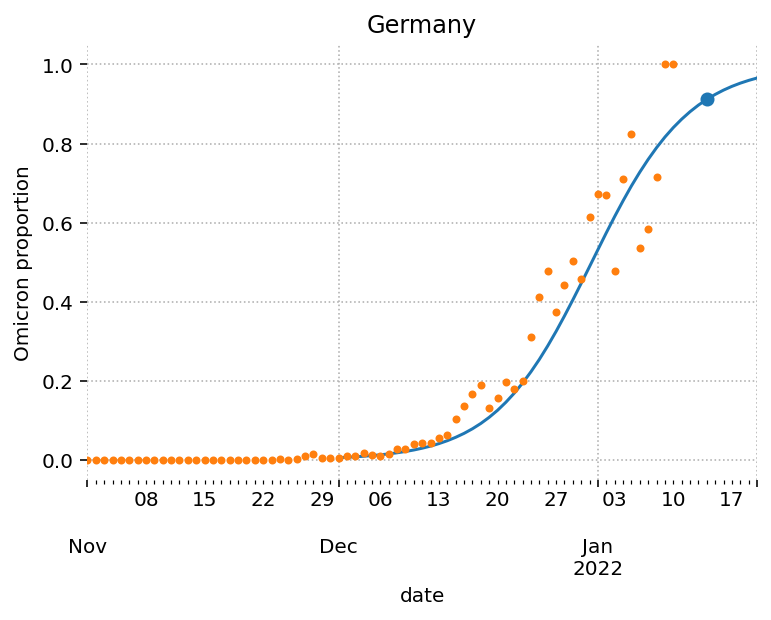

In [154]:
y = (1 - pd.DataFrame(f).sum(1) /pd.DataFrame(e).sum(1))
y.plot(ylabel = "Omicron proportion", xlabel="", title="Germany")
plt.scatter(np.datetime64('today'), y.loc[np.datetime64('today')])
foo = pd.crosstab(df.date, df.lineage.cat.remove_unused_categories())
(foo[ ['BA.1','BA.2','BA.3','B.1.1.529']].sum(1)/foo.sum(1)).plot(ls="",marker='.', legend=None)
#plt.yscale('logit')

(18962.0, 19012.0)

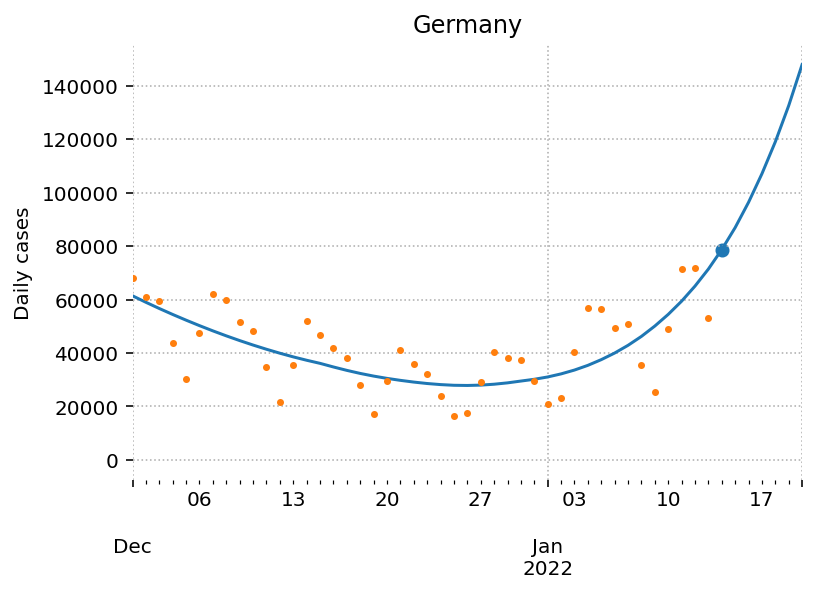

In [155]:
y = pd.DataFrame(e).sum(1)
y.plot(ylabel = "Daily cases", xlabel="", title="Germany")
plt.scatter(np.datetime64('today'), y.loc[np.datetime64('today')])
cases_land.sum(level=1).sort_index().plot(ls="", marker=".", markersize=5, ax=plt.gca(), xlabel="",label="", legend=None)
plt.xlim(("2021-12-01",None))